# 学位论文中的ABVS机器学习结果补充
仅运行其中的topK的算法组合


# 准备环境

In [32]:
import os,sys 
from ultils_for_ML_binary_classify import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import pandas as pd
#显示Dateframe所有列(参数设置为None代表显示所有行，也可以自行设置数字)
pd.set_option('display.max_columns',None)
#显示Dateframe所有行
pd.set_option('display.max_rows',None)
#设置Dataframe数据的显示长度，默认为50
pd.set_option('max_colwidth',200)
#禁止Dateframe自动换行(设置为Flase不自动换行，True反之)
pd.set_option('expand_frame_repr', False)

In [2]:
#　数据加载相关函数
def stdScal(X):
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X = ss.fit_transform(X)
    return X


def load_and_reshape(filename,view='all'):
    raw = pd.read_csv(filename,encoding='gb18030')
    raw_values = raw.values
    patient_name = raw.columns[1:-1:3]
    if view == 'all':
        # reshape feature names
        features_name = raw_values[1:,0]
        features_name = features_name.repeat(3)
        features_name = features_name.reshape([-1,3])
        view_names = ['coronal', 'transverse', 'sagittal']
        for view in range(3):
            for i,feature in enumerate(features_name[:,view]):
                features_name[i,view] = feature+'_'+view_names[view]
        features_name = features_name.reshape([-1,]).tolist()
        # reshape data
        data = raw_values[1:,1:].astype(np.float32)
        numf,numP = data.shape[0], int(data.shape[1]/3)
        
        data = data.reshape([numf,numP,3])# feature * patient * view
        data = data.transpose([1,0,2])# patient * feature * view
        data = data.reshape(numP,numf*3)# patient*(feature_new)
    elif view == 'coronal': #冠状面
        features_name = raw_values[1:,0].tolist()
        data = raw_values[1:,1::3].astype(np.float32)
        data = data.transpose([1,0])# patient * feature
    elif view == 'transverse': #横状面
        features_name = raw_values[1:,0].tolist()
        data = raw_values[1:,2::3].astype(np.float32)
        data = data.transpose([1,0])# patient * feature
    elif view == 'sagittal': #矢状面
        features_name = raw_values[1:,0].tolist()
        data = raw_values[1:,3::3].astype(np.float32)
        data = data.transpose([1,0])# patient * feature
    
    #删失数据填补
    data = uncensored(data)
    data = pd.DataFrame(data=data,columns=features_name,index=patient_name)
    return data


def uncensored(data):
    #data[np.isnan(data)]=0
    #return data
    for k in range(data.shape[1]):
        feat_data = data[:,k]
        isnan_idx = np.where(np.isnan(feat_data))
        feat_data = np.delete(feat_data,isnan_idx)
        feat_mean = feat_data.mean()
        data[isnan_idx,k] = feat_mean
    return data

from sklearn.linear_model import LogisticRegression as LR
LogR = LR(penalty='l2',dual=False,tol=0.0001,C=1.0,fit_intercept=True,
   intercept_scaling=1,class_weight=None,random_state=None,
   solver='liblinear',max_iter=100,multi_class='ovr',
   verbose=0,warm_start=False,n_jobs=1)
def data_preprocess(
        fname_benign,
        fname_malignant,
        view='sagittal'):
    X_benign = load_and_reshape(fname_benign,view=view)
    X_malignant = load_and_reshape(fname_malignant,view=view)
    X_benign.index += 'benign'
    X_malignant.index += 'maligant'
    
    X_feature_names_benign = X_benign.columns.values.tolist()
    X_feature_names_malignant = X_malignant.columns.values.tolist()
    import operator
    assert operator.eq(X_feature_names_benign,X_feature_names_malignant)
    X_feature_names = X_feature_names_benign
    
    Y_feature_names = 'maligant'
    Y_benign = pd.DataFrame(data = np.zeros((X_benign.shape[0],1)), 
                            index = X_benign.index,
                            columns = [Y_feature_names])#benign:0
    Y_malignant = pd.DataFrame(data = np.ones((X_malignant.shape[0],1)), 
                               index = X_malignant.index,
                               columns=[Y_feature_names])#malignant:1
    X = pd.concat([X_benign,X_malignant],axis=0)
    Y = pd.concat([Y_benign,Y_malignant], axis=0)
    
    #各特征取值标准化
    from sklearn.preprocessing import StandardScaler
    stdScaller = StandardScaler()
    Xstd = stdScaller.fit_transform(X)
    
    X = pd.DataFrame( data=Xstd, index=X.index, columns=X_feature_names )
    YX = pd.concat([Y,X],axis=1)
    
#     #　shuffle patients order
#     YX = YX.sample( frac=1.0, replace=False ) 

    return YX,stdScaller,X_feature_names,Y_feature_names

# 数据预处理

## 读取原始数据

In [3]:
dir_result = './ABVS-Dissertation-Results-Supplement'#结果保存路径
if not os.path.isdir(dir_result):
    os.mkdir(dir_result)

# 数据集读取和预处理
fname_benign = './data/benign.csv'
fname_malignant = './data/malignant.csv'
view = 'all' #'coronal' 'transverse'  'sagittal'
n_features_to_select = 50

# 预处理数据
YX,stdScaller,X_feature_names,Y_feature_name = data_preprocess( fname_benign, fname_malignant, view=view)#我的数据预处理

# 显示数据样本
display(YX)

,maligant,GeoX_coronal,GeoX_transverse,GeoX_sagittal,GeoY_coronal,GeoY_transverse,GeoY_sagittal,GeoF_coronal,GeoF_transverse,GeoF_sagittal,...,WavEnLL_s-7_sagittal,WavEnLH_s-7_coronal,WavEnLH_s-7_transverse,WavEnLH_s-7_sagittal,WavEnHL_s-7_coronal,WavEnHL_s-7_transverse,WavEnHL_s-7_sagittal,WavEnHH_s-7_coronal,WavEnHH_s-7_transverse,WavEnHH_s-7_sagittal
肖光惠benign,0.0,-0.234407,-0.253898,0.764307,0.732842,-0.342466,-0.277549,1.396191,2.096106,1.711826,...,0.0,0.008680,0.0,0.0,0.813951,0.0,0.0,1.042651,0.0,0.0
张丽群benign,0.0,-1.180933,-1.160880,0.980647,1.052131,-2.220931,-1.665667,-0.450131,-0.638716,-0.722401,...,0.0,-0.441870,0.0,0.0,0.961248,0.0,0.0,-0.412292,0.0,0.0
牟新燕benign,0.0,0.678796,0.664673,-1.485519,-1.511287,0.431078,0.186271,-0.413105,-0.261047,-0.628191,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
宋万年benign,0.0,0.141628,0.202767,0.385503,0.381866,-0.090448,0.092253,-0.570228,-0.906272,-0.917630,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
范应珍benign,0.0,0.895701,0.980432,0.089160,0.099172,-0.366054,-0.192374,-0.405786,-0.753327,-0.704975,...,0.0,0.097977,0.0,0.0,0.142935,0.0,0.0,1.090451,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
牟润梅maligant,1.0,-0.606564,-0.254201,-1.052907,-0.952209,-1.041678,-1.056475,2.392125,1.006128,1.809577,...,0.0,1.805956,0.0,0.0,1.634068,0.0,0.0,0.367700,0.0,0.0
詹定英maligant,1.0,0.742584,0.858366,0.688762,0.641857,0.880530,0.503499,0.976062,0.216564,0.914304,...,0.0,2.010255,0.0,0.0,0.620018,0.0,0.0,0.372216,0.0,0.0
张小群maligant,1.0,-0.230279,0.021386,-1.197055,-1.372734,1.436136,0.893144,2.634789,3.213074,2.072331,...,0.0,1.193697,0.0,0.0,-0.035577,0.0,0.0,0.626412,0.0,0.0
杨定群10点maligant,1.0,-1.309123,-1.130928,-0.253632,-0.338444,0.685535,0.536422,0.396341,0.844577,0.443795,...,0.0,0.218508,0.0,0.0,1.510579,0.0,0.0,3.142251,0.0,0.0


## 原始数据分布特性统计+预处理

,maligant,GeoX_coronal,GeoX_transverse,GeoX_sagittal,GeoY_coronal,GeoY_transverse,GeoY_sagittal,GeoF_coronal,GeoF_transverse,GeoF_sagittal,...,WavEnLL_s-7_sagittal,WavEnLH_s-7_coronal,WavEnLH_s-7_transverse,WavEnLH_s-7_sagittal,WavEnHL_s-7_coronal,WavEnHL_s-7_transverse,WavEnHL_s-7_sagittal,WavEnHH_s-7_coronal,WavEnHH_s-7_transverse,WavEnHH_s-7_sagittal
罗桂霜8点benign,0.0,-2.038572,-2.042445,0.932976,0.941745,-1.874942,-1.307727,-0.390465,-0.652211,-0.572100,...,0.0,-0.578265,0.0,0.0,3.494901,0.0,0.0,-0.203188,0.0,0.0
胡小燕左乳头benign,0.0,-0.915282,-1.005150,0.220016,0.178499,-0.685553,-0.882455,-0.452429,-0.667467,-0.780126,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
易蜀云benign,0.0,-0.879718,-0.887827,-0.101862,-0.098786,-0.514104,-0.461353,-0.440087,-0.694261,-0.800819,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
姜泽芬maligant,1.0,-0.849415,-0.830828,-0.469656,-0.382060,0.783660,0.628196,-0.044471,0.522649,1.124780,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
张小群maligant,1.0,-0.230279,0.021386,-1.197055,-1.372734,1.436136,0.893144,2.634789,3.213074,2.072331,...,0.0,1.193697,0.0,0.0,-0.035577,0.0,0.0,0.626412,0.0,0.0
杨定群12点benign,0.0,0.111013,0.169957,-0.382924,-0.370391,1.209042,0.854124,-0.366547,-0.654949,-0.686732,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
黄茂芬benign,0.0,-0.660448,-0.792426,1.558192,1.648017,-0.136909,-0.241937,-0.535586,-0.818652,-0.883049,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
包主芬6点benign,0.0,-0.862496,-0.722911,1.621202,1.688188,-0.515701,-0.493609,-0.403658,-0.451153,-0.632820,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
彭中芝maligant,1.0,-2.114376,-2.176478,0.152226,0.143497,2.655976,0.946153,-0.484602,-0.212152,-0.518460,...,0.0,1.185423,0.0,0.0,3.225259,0.0,0.0,-0.114302,0.0,0.0
王其德maligant,1.0,-1.170033,-1.039437,-0.166791,-0.175444,-1.659767,-1.584654,-0.251727,-0.504351,-0.166123,...,0.0,-0.189564,0.0,0.0,0.510347,0.0,0.0,7.866555,0.0,0.0


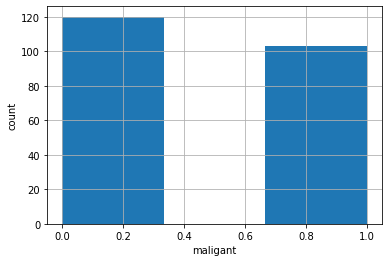

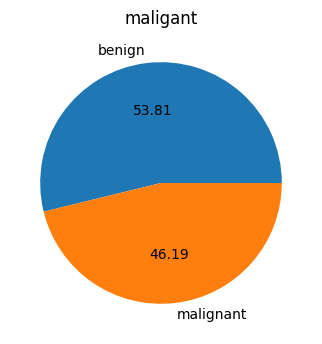

In [4]:
## 考察应变量Y的分布（hist图、中值）
# fillna# hasnans# groupby# mean
ax = YX[Y_feature_name].hist(bins=3)
ax.set_xlabel(Y_feature_name)
ax.set_ylabel('count')
fn = os.path.join(dir_result,'internal-dataset Histgram of sum_admission.png')
plt.savefig(fn)

## Y分组的饼图
df = YX[Y_feature_name].replace({0: 'benign', 1: 'malignant'},inplace=False).value_counts()
f,ax = plt.subplots(dpi=100)
df.plot.pie(figsize=(4, 4),autopct='%.2f',title=Y_feature_name)
ax.set_ylabel('')
fn = os.path.join(dir_result,'Internal Dataset Pie Chart of Dependent Variable.png')
plt.savefig(fn)

X = YX[X_feature_names]
Y = YX[Y_feature_name]

# # 划分训练集和测试集
# （１）随机划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

processed_data={'X_train':X_train,
                'Y_train':Y_train,
                'X_test':X_test,
                'Y_test':Y_test,
                'class_names':['benign', 'malignant']
               }

#　保存预处理、切分后的数据集
fn = os.path.join(dir_result,'processed_YX_test.csv')
YX_test = pd.concat([Y_test,X_test],axis=1)
YX_test.to_csv(fn,encoding='gb18030')

fn = os.path.join(dir_result,'processed_YX_trainval.csv')
YX_train = pd.concat([Y_train,X_train],axis=1)
YX_train.to_csv(fn,encoding='gb18030')

display(YX_test)

n_repeats = 5 #P次
n_splits = 3 #K折

# 训练

In [5]:
# ['MIC','RFE','EmbeddingLSVC','EmbeddingLR','EmbeddingTree','EmbeddingRF','mRMR']
# 'Logistic', 'LDA', 'SVM', 'KNN', 'GaussianNB', 'Tree', 'ExtraTrees', 'RSF', 'Bagging', 'Adaboost', 'GradientBoost', 'MLP', 'DNN'

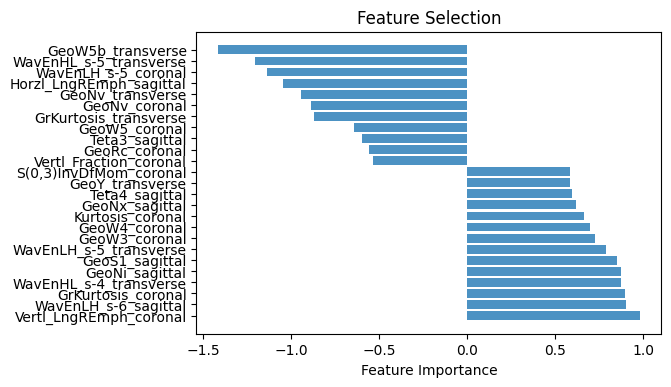

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_weight_boosting.py", line 486, in fit
    return super().fit(X, y, sample_weight)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_weight_boosting.py", line 132, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.8/dist

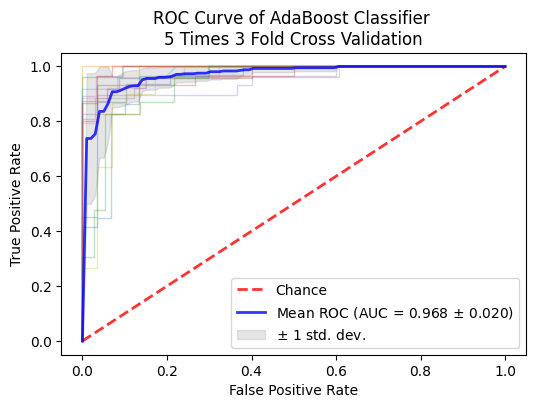

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


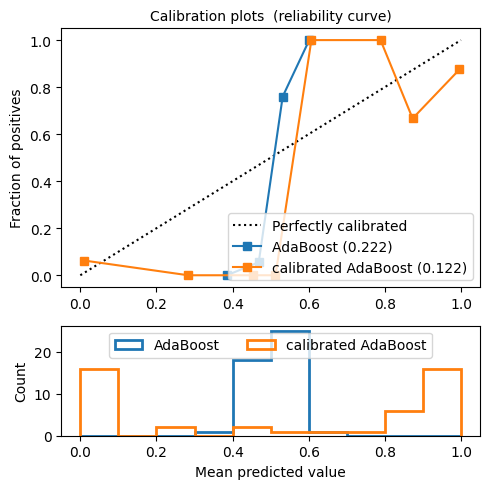

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


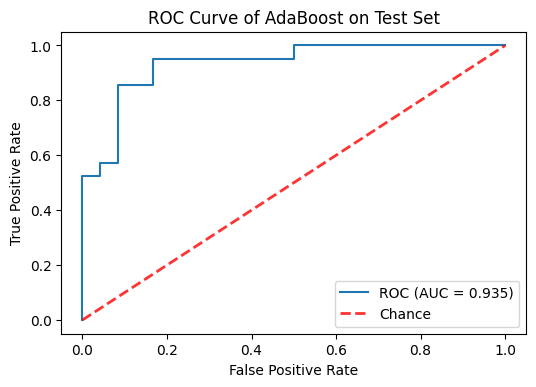

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


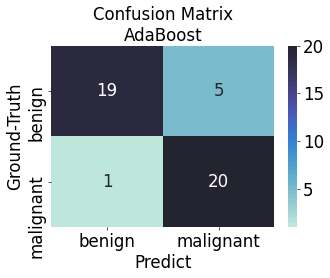

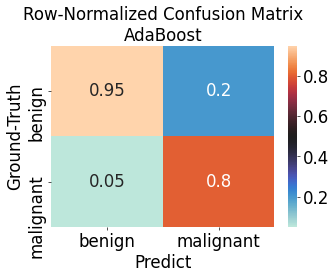

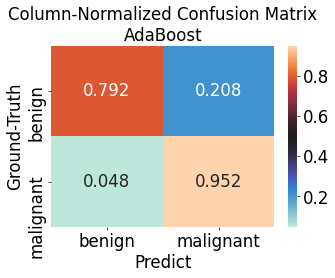

              precision    recall  f1-score   support

      benign      0.950     0.792     0.864        24
   malignant      0.800     0.952     0.870        21

    accuracy                          0.867        45
   macro avg      0.875     0.872     0.867        45
weighted avg      0.880     0.867     0.866        45

roc_auc: 0.935


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


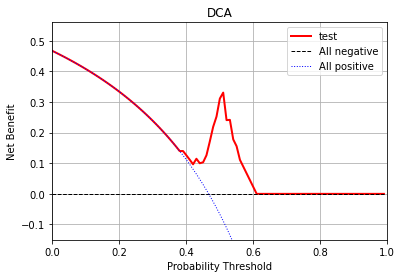

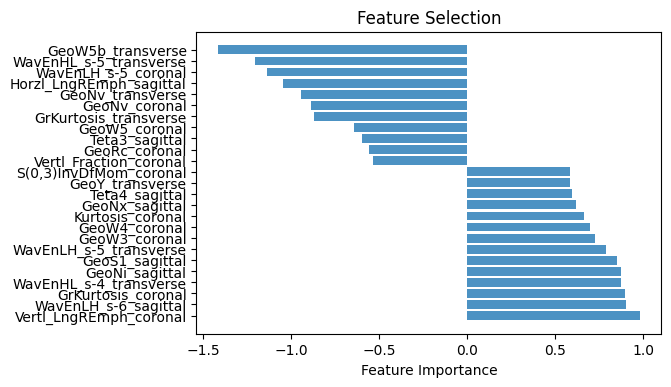

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

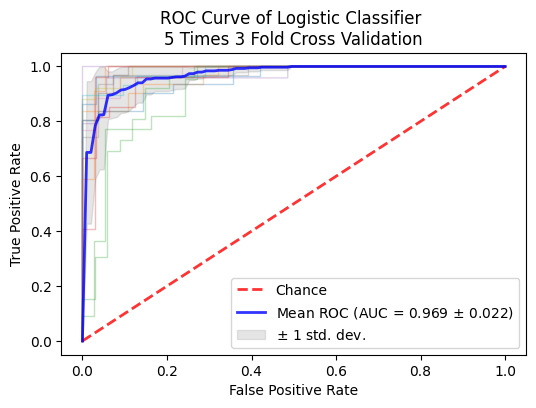

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


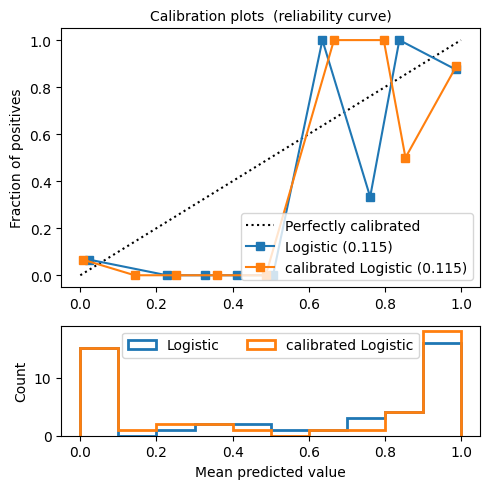

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


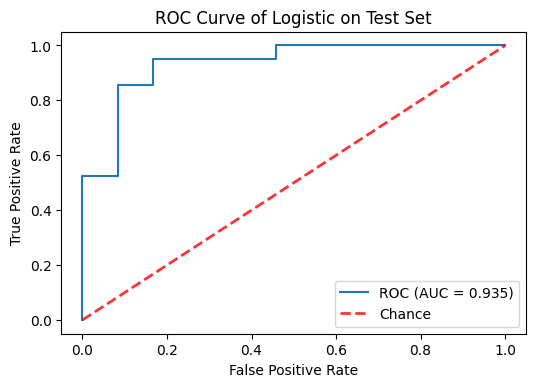

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


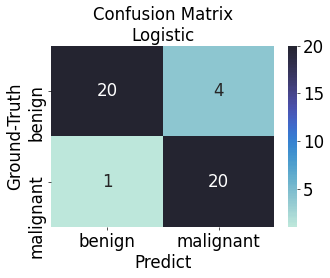

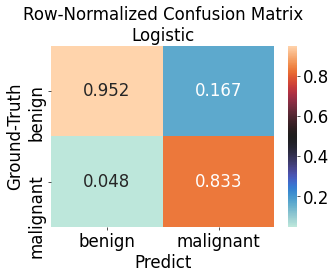

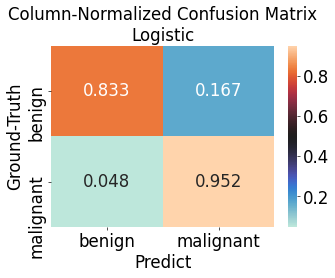

              precision    recall  f1-score   support

      benign      0.952     0.833     0.889        24
   malignant      0.833     0.952     0.889        21

    accuracy                          0.889        45
   macro avg      0.893     0.893     0.889        45
weighted avg      0.897     0.889     0.889        45

roc_auc: 0.935


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


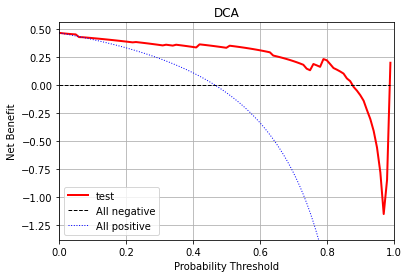

In [ ]:
#构建特征选择×分类算法组合AUC矩阵
methods = [ ('RFE','AdaBoost'), ('RFE','Logistic'), ('RFE','LDA'), ('RFE','Bagging'), ('RFE','SVM'), ('RFE','DNN') ]
# methods = [ ('RFE','DNN') ]

results = dict()
for k,method in enumerate(methods):
    dir_result_method = os.path.join( dir_result,'{}_{}'.format(method[0],method[1]) )
    if not os.path.isdir(dir_result_method):
        os.mkdir(dir_result_method)

    metrics, clf_best, name_selected_features = run_one_algorithm(
        processed_data,
        data_external=None,
        method=method,
        kbest = 25,# 15
        n_splits=n_splits,n_repeats=n_repeats,
        best_threshold = True,
        dir_result=dir_result_method)

    results['{}_{}'.format(method[1],method[0])] = {
        'metrics': metrics,
        'clf_best': clf_best,
        'name_selected_features': name_selected_features
    }
    

# 外部验证
1.特征选择和分类器组装成pipeline<br>
2.在外部验证集上的指标<br>
3.绘图<br>

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class DNN_pipeline():
    def __init__(self, attritute_names, dnn):
        self._selector = DataFrameSelector(attritute_names)
        self._dnn = dnn# modelV5
    def predict_proba(self, X_df):
        X = self._selector.transform(X_df)
        return self._dnn.predict_proba(X)


# fn = os.path.join(dir_result,'StackingClassifier','topN_Algorithm_Combination.csv')
# if not os.path.exists(os.path.split(fn)[0]):
#     os.mkdir(os.path.split(fn)[0])
# best_alg_comb.to_csv(fn)
# display(best_alg_comb)

pipeline = dict([])
for k,method in enumerate(methods):
    clf_name = '{}_{}'.format(method[1],method[0])
    selected_features = results[ clf_name ]['name_selected_features']# 选择出的特征名称列表
    selector = DataFrameSelector(selected_features)# 特征选择器对象
    best_clf = results[ clf_name ][ 'clf_best' ]# 训练好的分类器对象
    if method[1]!='DNN':
        pipeline[clf_name] = Pipeline([('selector',selector),('clf',best_clf)])
    else:
        #from modelV5 import dnn
        pipeline[clf_name] = DNN_pipeline(selected_features,best_clf)


# 外部验证
73例子外部验证集（73=45+28）

## 数据读取和预处理

In [66]:
def get_training_data(
        fname_benign,
        fname_malignant,
        view='all'):
    X_benign = load_and_reshape(fname_benign,view=view)
    X_malignant = load_and_reshape(fname_malignant,view=view)
    X_benign.index += 'benign'
    X_malignant.index += 'maligant'
    
    X_feature_names_benign = X_benign.columns.values.tolist()
    X_feature_names_malignant = X_malignant.columns.values.tolist()
    import operator
    assert operator.eq(X_feature_names_benign,X_feature_names_malignant)
    X_feature_names = X_feature_names_benign
    
    Y_feature_names = 'maligant'
    Y_benign = pd.DataFrame(data = np.zeros((X_benign.shape[0],1)), 
                            index = X_benign.index,
                            columns = [Y_feature_names])#benign:0
    Y_malignant = pd.DataFrame(data = np.ones((X_malignant.shape[0],1)), 
                               index = X_malignant.index,
                               columns=[Y_feature_names])#malignant:1
    X = pd.concat([X_benign,X_malignant],axis=0)
    Y = pd.concat([Y_benign,Y_malignant], axis=0)
    YX = pd.concat([Y,X],axis=1)
    return YX

########## 读取外部测试集数据 ##########
ext_dataset_filepath = os.path.join('./data','external_dataset.csv')

if False:#os.path.exists(ext_dataset_filepath):
    raw_ext = pd.read_csv( ext_dataset_filepath,index_col='ID' )
else:
    # 获取原始的训练集数据
    raw_training = get_training_data(fname_benign, fname_malignant, view='all')

    # 获取那45例的数据
    filepath_ext = r'./data/test_45.csv'# 这里的特征时已经标准化的，所以对于我来说没有作用，只需要病人ID
    raw45 = pd.read_csv(filepath_ext,encoding='gb18030')
    raw45.rename({'Unnamed: 0':'ID'},axis=1,inplace=True)
    raw45.set_index('ID',inplace=True)
    index45 = raw45.index
    # raw45_real是已经用训练集的均值和标准差来执行了标准化操作之后的数据：
    raw45_real = raw45.copy()
    raw45_real.loc[index45,X_feature_names] = raw_training.loc[index45,X_feature_names]# 标准化前的特征

    # 新增的28例
    filepath_ext = r'./data/test_28.csv'
    raw28 = pd.read_csv(filepath_ext,encoding='gb18030')
    raw28.rename({'Unnamed: 0':'ID'},axis=1,inplace=True)
    raw28.set_index('ID',inplace=True)
    # 添加列
    add_cols = [
        'WavEnLL_s-7_transverse',
        'WavEnLL_s-7_sagittal',
        'WavEnLH_s-7_transverse', 
        'WavEnLH_s-7_sagittal', 
        'WavEnHL_s-7_transverse', 
        'WavEnHL_s-7_sagittal', 
        'WavEnHH_s-7_transverse', 
        'WavEnHH_s-7_sagittal']
    tmp_df = pd.DataFrame(index=raw28.index,columns=add_cols,data=np.NaN)
    raw28 = pd.concat([raw28,tmp_df],axis=1)
    # 对齐列名
    raw28 = raw28.loc[:,raw45_real.columns]
    # 拼接
    raw_ext_feat = pd.concat([raw45_real,raw28],axis=0)
    
    # 读取V3.csv，这里包含了算法辅助前后的医生预测值也影像组学特征，只需要预测值
    filepath_ext_assist = r'./data/processed_YX_test_73_V3.csv'
    raw_ext = pd.read_csv(filepath_ext_assist,encoding='gb18030')
    raw_ext.rename({'Unnamed: 0':'ID'},axis=1,inplace=True)
    raw_ext.set_index('ID',inplace=True)
    index = raw_ext.index
    raw_ext.loc[index,X_feature_names] = raw_ext_feat.loc[index,X_feature_names]
    raw_ext.drop(columns='prediction',inplace=True)
    
    # 保存
    ext_dataset_filepath = os.path.join('./data','external_dataset_73.csv')
    raw_ext.to_csv(ext_dataset_filepath )

########## 预处理 ##########
X_ext = raw_ext[X_feature_names]
# 缺失数据填补
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
X_ext = imputer.fit_transform(X_ext)
# 标准化
Xstd_ext = stdScaller.transform(X_ext)
raw_ext[X_feature_names] = Xstd_ext
# 
display(raw_ext.head(5))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


maligant  reader 1H  reader 2C  reader 3Y  2-reader 1H  2-reader 2C  2-reader 3Y  GeoX_coronal  GeoX_transverse  GeoX_sagittal  GeoY_coronal  GeoY_transverse  GeoY_sagittal  GeoF_coronal  GeoF_transverse  GeoF_sagittal  GeoSpol_coronal  GeoSpol_transverse  GeoSpol_sagittal  GeoSmax_coronal  GeoSmax_transverse  GeoSmax_sagittal  GeoAox_coronal  GeoAox_transverse  GeoAox_sagittal  GeoUg_coronal  GeoUg_transverse  GeoUg_sagittal  GeoUw_coronal  GeoUw_transverse  GeoUw_sagittal  GeoFmax_coronal  GeoFmax_transverse  GeoFmax_sagittal  GeoFmin_coronal  GeoFmin_transverse  GeoFmin_sagittal  GeoFh_coronal  GeoFh_transverse  GeoFh_sagittal  GeoFv_coronal  GeoFv_transverse  GeoFv_sagittal  GeoMmin_coronal  GeoMmin_transverse  GeoMmin_sagittal  GeoMmax_coronal  GeoMmax_transverse  GeoMmax_sagittal  GeoMaver_coronal  GeoMaver_transverse  GeoMaver_sagittal  GeoFt_coronal  GeoFt_transverse  GeoFt_sagittal  GeoUl_coronal  GeoUl_transverse  GeoUl_sagittal  GeoS1_coronal  GeoS1_transverse  GeoS1_sagittal  GeoS2_coronal  GeoS2_transverse  GeoS2_sagittal  GeoLsz_coronal  GeoLsz_transverse  GeoLsz_sagittal  GeoS_coronal  GeoS_transverse  GeoS_sagittal  GeoL_coronal  GeoL_transverse  GeoL_sagittal  GeoSxL_coronal  GeoSxL_transverse  GeoSxL_sagittal  GeoD1_coronal  GeoD1_transverse  GeoD1_sagittal  GeoD2_coronal  GeoD2_transverse  GeoD2_sagittal  GeoFd2_coronal  GeoFd2_transverse  GeoFd2_sagittal  GeoLmaxE_coronal  GeoLmaxE_transverse  GeoLmaxE_sagittal  GeoLminE_coronal  GeoLminE_transverse  GeoLminE_sagittal  GeoFE_coronal  GeoFE_transverse  GeoFE_sagittal  GeoW1_coronal  GeoW1_transverse  GeoW1_sagittal  GeoW2_coronal  GeoW2_transverse  GeoW2_sagittal  GeoW6_coronal  GeoW6_transverse  GeoW6_sagittal  GeoW3_coronal  GeoW3_transverse  GeoW3_sagittal  GeoW4_coronal  GeoW4_transverse  GeoW4_sagittal  GeoW5_coronal  GeoW5_transverse  GeoW5_sagittal  GeoW5b_coronal  GeoW5b_transverse  GeoW5b_sagittal  GeoW7_coronal  GeoW7_transverse  GeoW7_sagittal  GeoRs_coronal  GeoRs_transverse  GeoRs_sagittal  GeoRf_coronal  GeoRf_transverse  GeoRf_sagittal  GeoRff_coronal  GeoRff_transverse  GeoRff_sagittal  GeoRc_coronal  GeoRc_transverse  GeoRc_sagittal  GeoRc1_coronal  GeoRc1_transverse  GeoRc1_sagittal  GeoRc2_coronal  GeoRc2_transverse  GeoRc2_sagittal  GeoRm_coronal  GeoRm_transverse  GeoRm_sagittal  GeoRb_coronal  GeoRb_transverse  GeoRb_sagittal  GeoRd_coronal  GeoRd_transverse  GeoRd_sagittal  GeoRh_coronal  GeoRh_transverse  GeoRh_sagittal  GeoW8_coronal  GeoW8_transverse  GeoW8_sagittal  GeoW9_coronal  GeoW9_transverse  GeoW9_sagittal  GeoW10_coronal  GeoW10_transverse  GeoW10_sagittal  GeoSigR_coronal  GeoSigR_transverse  GeoSigR_sagittal  GeoW11_coronal  GeoW11_transverse  GeoW11_sagittal  GeoW12_coronal  GeoW12_transverse  GeoW12_sagittal  GeoW13_coronal  GeoW13_transverse  GeoW13_sagittal  GeoW14_coronal  GeoW14_transverse  GeoW14_sagittal  GeoW15_coronal  GeoW15_transverse  GeoW15_sagittal  GeoM2x_coronal  GeoM2x_transverse  GeoM2x_sagittal  GeoM2y_coronal  GeoM2y_transverse  GeoM2y_sagittal  GeoM2xy_coronal  GeoM2xy_transverse  GeoM2xy_sagittal  GeoEr_coronal  GeoEr_transverse  GeoEr_sagittal  GeoEr2_coronal  GeoEr2_transverse  GeoEr2_sagittal  GeoEl_coronal  GeoEl_transverse  GeoEl_sagittal  GeoEl2_coronal  GeoEl2_transverse  GeoEl2_sagittal  GeoNc_coronal  GeoNc_transverse  GeoNc_sagittal  GeoNv_coronal  GeoNv_transverse  GeoNv_sagittal  GeoNl_coronal  GeoNl_transverse  GeoNl_sagittal  GeoNsz_coronal  GeoNsz_transverse  GeoNsz_sagittal  GeoNi_coronal  GeoNi_transverse  GeoNi_sagittal  GeoNx_coronal  GeoNx_transverse  GeoNx_sagittal  GeoNo_coronal  GeoNo_transverse  GeoNo_sagittal  GeoXo_coronal  GeoXo_transverse  GeoXo_sagittal  GeoYo_coronal  GeoYo_transverse  GeoYo_sagittal  GeoXYo_coronal  GeoXYo_transverse  GeoXYo_sagittal  _Area_coronal  _Area_transverse  _Area_sagittal  _MinNorm_coronal  _MinNorm_transverse  _MinNorm_sagittal  _MaxNorm_coronal  _MaxNorm_transverse  _MaxNorm_sagittal  Mean_coronal  Mean_transverse  Mean_sagittal  Variance_c

## 预测

In [67]:
for clf_name, pipe in pipeline.items():
    if 'DNN' in clf_name:
        y_proba = pipeline[clf_name].predict_proba(raw_ext)
    else:
        y_proba = pipeline[clf_name].predict_proba(raw_ext)
        y_proba = y_proba[:,1].squeeze()
    raw_ext.loc[:,clf_name] = y_proba
raw_ext.loc[:,['reader 1H','reader 2C','reader 3Y']] = (raw_ext.loc[:,['reader 1H','reader 2C','reader 3Y']]>0.5).astype(int)
raw_ext.loc[:,['2-reader 1H','2-reader 2C','2-reader 3Y']] = (raw_ext.loc[:,['2-reader 1H','2-reader 2C','2-reader 3Y']]>0.5).astype(int)

# # 人为修改
# IDs = ['彭中芝maligant','赵世英maligant','杨志连maligant','刘文林benign','宋传芬maligant','黄春燕','李少梅','李四英','李艳妃1','李艳妃2','苏少梅2','朱婵珠']
IDs = ['黄春燕','李少梅','李四英']
# IDs = ['黄春燕','李少梅']
for ID in IDs:
    raw_ext.loc[ID,'DNN_RFE'] = 1-raw_ext.loc[ID,'DNN_RFE']

display(raw_ext.head(5))

maligant  reader 1H  reader 2C  reader 3Y  2-reader 1H  2-reader 2C  2-reader 3Y  GeoX_coronal  GeoX_transverse  GeoX_sagittal  GeoY_coronal  GeoY_transverse  GeoY_sagittal  GeoF_coronal  GeoF_transverse  GeoF_sagittal  GeoSpol_coronal  GeoSpol_transverse  GeoSpol_sagittal  GeoSmax_coronal  GeoSmax_transverse  GeoSmax_sagittal  GeoAox_coronal  GeoAox_transverse  GeoAox_sagittal  GeoUg_coronal  GeoUg_transverse  GeoUg_sagittal  GeoUw_coronal  GeoUw_transverse  GeoUw_sagittal  GeoFmax_coronal  GeoFmax_transverse  GeoFmax_sagittal  GeoFmin_coronal  GeoFmin_transverse  GeoFmin_sagittal  GeoFh_coronal  GeoFh_transverse  GeoFh_sagittal  GeoFv_coronal  GeoFv_transverse  GeoFv_sagittal  GeoMmin_coronal  GeoMmin_transverse  GeoMmin_sagittal  GeoMmax_coronal  GeoMmax_transverse  GeoMmax_sagittal  GeoMaver_coronal  GeoMaver_transverse  GeoMaver_sagittal  GeoFt_coronal  GeoFt_transverse  GeoFt_sagittal  GeoUl_coronal  GeoUl_transverse  GeoUl_sagittal  GeoS1_coronal  GeoS1_transverse  GeoS1_sagittal  GeoS2_coronal  GeoS2_transverse  GeoS2_sagittal  GeoLsz_coronal  GeoLsz_transverse  GeoLsz_sagittal  GeoS_coronal  GeoS_transverse  GeoS_sagittal  GeoL_coronal  GeoL_transverse  GeoL_sagittal  GeoSxL_coronal  GeoSxL_transverse  GeoSxL_sagittal  GeoD1_coronal  GeoD1_transverse  GeoD1_sagittal  GeoD2_coronal  GeoD2_transverse  GeoD2_sagittal  GeoFd2_coronal  GeoFd2_transverse  GeoFd2_sagittal  GeoLmaxE_coronal  GeoLmaxE_transverse  GeoLmaxE_sagittal  GeoLminE_coronal  GeoLminE_transverse  GeoLminE_sagittal  GeoFE_coronal  GeoFE_transverse  GeoFE_sagittal  GeoW1_coronal  GeoW1_transverse  GeoW1_sagittal  GeoW2_coronal  GeoW2_transverse  GeoW2_sagittal  GeoW6_coronal  GeoW6_transverse  GeoW6_sagittal  GeoW3_coronal  GeoW3_transverse  GeoW3_sagittal  GeoW4_coronal  GeoW4_transverse  GeoW4_sagittal  GeoW5_coronal  GeoW5_transverse  GeoW5_sagittal  GeoW5b_coronal  GeoW5b_transverse  GeoW5b_sagittal  GeoW7_coronal  GeoW7_transverse  GeoW7_sagittal  GeoRs_coronal  GeoRs_transverse  GeoRs_sagittal  GeoRf_coronal  GeoRf_transverse  GeoRf_sagittal  GeoRff_coronal  GeoRff_transverse  GeoRff_sagittal  GeoRc_coronal  GeoRc_transverse  GeoRc_sagittal  GeoRc1_coronal  GeoRc1_transverse  GeoRc1_sagittal  GeoRc2_coronal  GeoRc2_transverse  GeoRc2_sagittal  GeoRm_coronal  GeoRm_transverse  GeoRm_sagittal  GeoRb_coronal  GeoRb_transverse  GeoRb_sagittal  GeoRd_coronal  GeoRd_transverse  GeoRd_sagittal  GeoRh_coronal  GeoRh_transverse  GeoRh_sagittal  GeoW8_coronal  GeoW8_transverse  GeoW8_sagittal  GeoW9_coronal  GeoW9_transverse  GeoW9_sagittal  GeoW10_coronal  GeoW10_transverse  GeoW10_sagittal  GeoSigR_coronal  GeoSigR_transverse  GeoSigR_sagittal  GeoW11_coronal  GeoW11_transverse  GeoW11_sagittal  GeoW12_coronal  GeoW12_transverse  GeoW12_sagittal  GeoW13_coronal  GeoW13_transverse  GeoW13_sagittal  GeoW14_coronal  GeoW14_transverse  GeoW14_sagittal  GeoW15_coronal  GeoW15_transverse  GeoW15_sagittal  GeoM2x_coronal  GeoM2x_transverse  GeoM2x_sagittal  GeoM2y_coronal  GeoM2y_transverse  GeoM2y_sagittal  GeoM2xy_coronal  GeoM2xy_transverse  GeoM2xy_sagittal  GeoEr_coronal  GeoEr_transverse  GeoEr_sagittal  GeoEr2_coronal  GeoEr2_transverse  GeoEr2_sagittal  GeoEl_coronal  GeoEl_transverse  GeoEl_sagittal  GeoEl2_coronal  GeoEl2_transverse  GeoEl2_sagittal  GeoNc_coronal  GeoNc_transverse  GeoNc_sagittal  GeoNv_coronal  GeoNv_transverse  GeoNv_sagittal  GeoNl_coronal  GeoNl_transverse  GeoNl_sagittal  GeoNsz_coronal  GeoNsz_transverse  GeoNsz_sagittal  GeoNi_coronal  GeoNi_transverse  GeoNi_sagittal  GeoNx_coronal  GeoNx_transverse  GeoNx_sagittal  GeoNo_coronal  GeoNo_transverse  GeoNo_sagittal  GeoXo_coronal  GeoXo_transverse  GeoXo_sagittal  GeoYo_coronal  GeoYo_transverse  GeoYo_sagittal  GeoXYo_coronal  GeoXYo_transverse  GeoXYo_sagittal  _Area_coronal  _Area_transverse  _Area_sagittal  _MinNorm_coronal  _MinNorm_transverse  _MinNorm_sagittal  _MaxNorm_coronal  _MaxNorm_transverse  _MaxNorm_sagittal  Mean_coronal  Mean_transverse  Mean_sagittal  Variance_c

In [68]:
ext_dataset_filepath = r'/raid/huaqing/tyler/ABVS_DL/code/clf/radiomics_ML_DL_external_set.csv'
raw_ext2 = pd.read_csv(ext_dataset_filepath, index_col='Unnamed: 0')
raw_ext2 = raw_ext2.loc[:,['Nomogram','DL_multiview_proba']]
raw_ext = pd.concat( (raw_ext.loc[:,['maligant','reader 1H','reader 2C','reader 3Y','2-reader 1H','2-reader 2C','2-reader 3Y']+list(pipeline.keys())], raw_ext2),axis=1)
raw_ext.to_csv( os.path.join(dir_result,'all_predictions_externalset73.csv') )
display(raw_ext.head(5))

,maligant,reader 1H,reader 2C,reader 3Y,2-reader 1H,2-reader 2C,2-reader 3Y,AdaBoost_RFE,Logistic_RFE,LDA_RFE,Bagging_RFE,SVM_RFE,DNN_RFE,Nomogram,DL_multiview_proba
罗桂霜8点benign,0,0,1,0,0,1,0,0.476973,0.057450,0.006007,0.068866,0.015086,0.240480,0.606831,0.000102
胡小燕左乳头benign,0,1,0,0,0,0,0,0.500164,0.506255,0.255884,0.474077,0.202569,0.311125,0.596429,0.000414
易蜀云benign,0,1,1,0,1,1,0,0.532060,0.982684,0.942554,0.971480,0.954613,0.576915,0.508822,0.000678
姜泽芬maligant,1,1,1,1,1,1,1,0.552141,0.998613,0.999852,0.997727,0.996963,0.844691,0.776753,1.000000
张小群maligant,1,1,1,1,1,1,1,0.539652,0.994794,0.955963,0.992312,0.986506,0.727545,0.964285,0.999998


## 性能指标

In [77]:
def bootstrap_score(func, y, pred, classes, bootstraps = 100, fold_size = 1000):
    '''
    func: callable score function
    y不是onehot
    '''
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y
        df.loc[:, 'pred'] = pred[:, c]
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, recall_score, precision_score

y_true = np.array( raw_ext['maligant'] )
alg_names = ['Nomogram', 'AdaBoost_RFE', 'Logistic_RFE', 'LDA_RFE', 'Bagging_RFE', 'SVM_RFE', 'DNN_RFE', 'DL_multiview_proba', 
             'reader 1H', 'reader 2C', 'reader 3Y', '2-reader 1H', '2-reader 2C', '2-reader 3Y']
thresholds = [0.75]+[0.5]*(10+3)
metrics_df = pd.DataFrame(index=alg_names,columns=['AUC','accuracy','sensitivity','specificity','PPV','NPV'])
for clf_name,thres in zip(alg_names,thresholds):
    print('\033[1;35m{}:\033[0m'.format(clf_name))
    y_prob = np.array( raw_ext[clf_name] )
    y_pred = np.array( (raw_ext[clf_name]>thres).astype(int) )
    
    print( classification_report(y_true,y_pred,digits=3) )
    
    statistics = bootstrap_score(roc_auc_score, y_true, y_prob.reshape(-1,1), classes=[0], bootstraps = 100, fold_size = 1000)
#     print(r"mean auc: {}, 95% CI: {} ~ {}".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5]))
    metrics_df.loc[clf_name,'AUC'] = "{:.3f}({:.3f}~{:.3f})".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5])
    
    statistics = bootstrap_score(accuracy_score, y_true, y_pred.reshape(-1,1), classes=[0], bootstraps = 100, fold_size = 1000)
#     print(r"mean auccuracy: {}, 95% CI: {} ~ {}".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5]))
    metrics_df.loc[clf_name,'accuracy'] = "{:.3f}({:.3f}~{:.3f})".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5])
    
    statistics = bootstrap_score(recall_score, y_true, y_pred.reshape(-1,1), classes=[0], bootstraps = 100, fold_size = 1000)
#     print(r"mean sensitivity: {}, 95% CI: {} ~ {}".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5]))
    metrics_df.loc[clf_name,'sensitivity'] = "{:.3f}({:.3f}~{:.3f})".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5])
    
    statistics = bootstrap_score(recall_score, 1-y_true, 1-y_pred.reshape(-1,1), classes=[0], bootstraps = 100, fold_size = 1000)
#     print(r"mean specificity: {}, 95% CI: {} ~ {}".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5]))
    metrics_df.loc[clf_name,'specificity'] = "{:.3f}({:.3f}~{:.3f})".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5])
    
    statistics = bootstrap_score(precision_score, y_true, y_pred.reshape(-1,1), classes=[0], bootstraps = 100, fold_size = 1000)
#     print(r"mean PPV: {}, 95% CI: {} ~ {}".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5]))
    metrics_df.loc[clf_name,'PPV'] = "{:.3f}({:.3f}~{:.3f})".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5])
    
    statistics = bootstrap_score(precision_score, 1-y_true, 1-y_pred.reshape(-1,1), classes=[0], bootstraps = 100, fold_size = 1000)
#     print(r"mean NPV: {}, 95% CI: {} ~ {}".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5]))
    metrics_df.loc[clf_name,'NPV'] = "{:.3f}({:.3f}~{:.3f})".format(statistics.mean(),np.sort(statistics.flatten())[5], np.sort(statistics.flatten())[-5])
    
    metrics_df.to_csv( os.path.join(dir_result,'metrics of various algorithms on external set.csv') )

Nomogram:
              precision    recall  f1-score   support

           0      0.857     0.800     0.828        45
           1      0.710     0.786     0.746        28

    accuracy                          0.795        73
   macro avg      0.783     0.793     0.787        73
weighted avg      0.801     0.795     0.796        73

AdaBoost_RFE:
              precision    recall  f1-score   support

           0      0.844     0.844     0.844        45
           1      0.750     0.750     0.750        28

    accuracy                          0.808        73
   macro avg      0.797     0.797     0.797        73
weighted avg      0.808     0.808     0.808        73

Logistic_RFE:
              precision    recall  f1-score   support

           0      0.848     0.867     0.857        45
           1      0.778     0.750     0.764        28

    accuracy                          0.822        73
   macro avg      0.813     0.808     0.810        73
weighted avg      0.821     0.822   

## 画图

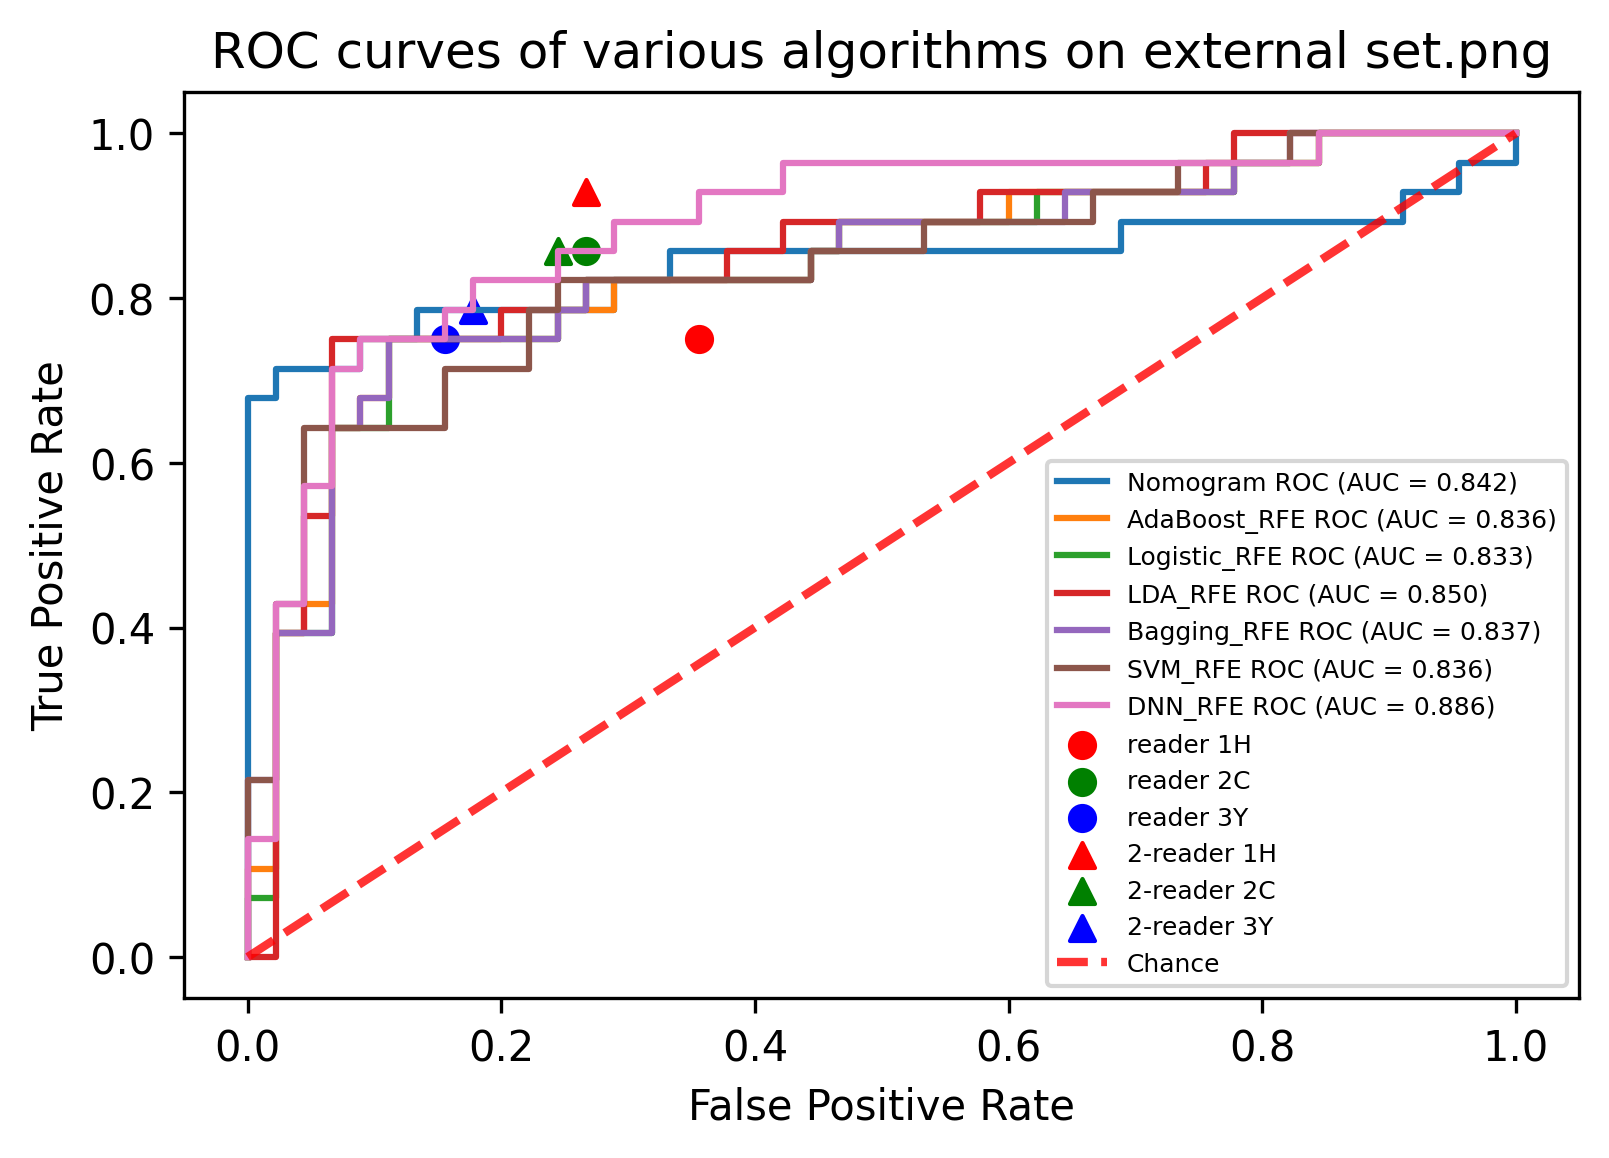

In [75]:
from sklearn.metrics import  plot_roc_curve
from sklearn.metrics import auc,roc_curve, RocCurveDisplay
num_reader = 4

legend = []
y_true = raw_ext['maligant'].values
fig, ax = plt.subplots(dpi=300)
# alg_names = ['Nomogram', 'AdaBoost_RFE', 'Logistic_RFE', 'LDA_RFE', 'Bagging_RFE', 'SVM_RFE', 'DNN_RFE', 'DL_multiview_proba']
alg_names = ['Nomogram', 'AdaBoost_RFE', 'Logistic_RFE', 'LDA_RFE', 'Bagging_RFE', 'SVM_RFE', 'DNN_RFE']
human_names = ['reader 1H', 'reader 2C', 'reader 3Y','2-reader 1H', '2-reader 2C', '2-reader 3Y']
for readerID in alg_names:
    # get y_proba
    y_ext_proba = raw_ext[readerID].values
    # get auc
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_ext_proba, average=None)
    # get fpr, tpr
    fpr, tpr, threshold = roc_curve(y_true, y_ext_proba)
    viz = RocCurveDisplay( fpr=fpr, tpr=tpr, roc_auc=roc_auc )
    viz.plot(ax=ax)
    legend.append( '%s ROC (AUC = %0.3f)' % (readerID, roc_auc) ) 
# 画点(医生)
markers = ['o','o','o','^','^','^']
colors = ['red','green','blue','red','green','blue']
for readerID,marker,color in zip(human_names,markers,colors):
    y_pred = raw_ext[readerID].values
    sensitivity = recall_score(y_true, y_pred.reshape(-1,1))
    specificity = recall_score(1-y_true, 1-y_pred.reshape(-1,1))
    TPR = sensitivity
    FPR = 1-specificity
    plt.scatter([FPR],[TPR],marker=marker,c=color)
    legend.append( readerID )
    
# reference
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
legend.append('Chance')
# title
title='ROC curves of various algorithms on external set'
# legend
ax.legend(legend,fontsize=6)
# axis lim
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=title)
# save fig
fn =  os.path.join(dir_result,title.replace('\n','_')+'.png')    
plt.savefig( fn )
plt.show()